In [42]:
from pytorch_tabnet.tab_model import TabNetClassifier

import torch
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
np.random.seed(0)

import os, sys; 
column_path = os.path.dirname(os.path.realpath('C:/Users/sgopalakrish/Downloads/intellizenz-model-training/Neuro-symbolic-AI/column.py'))
if sys.path.__contains__(column_path)==False:
    sys.path.append(column_path)

from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.augmentations import ClassificationSMOTE

import column
import wandb
from matplotlib import pyplot as plt
%matplotlib inline

## ===============================================

## 1. Load data and split

In [2]:
target = "veranst_segment"
# feature_columns = column.features_v5  #143 features
feature_columns = column.features_v6  #80 features

data_path = column.data_path_2016_2020_v3
df = pd.read_parquet(data_path)


# class_frequency = df.groupby('veranst_segment')['veranst_segment'].transform('count')
# df_sampled = df.sample(n=70000, weights=class_frequency, random_state=2)

# df_sampled = df_sampled[feature_columns]
df_sampled = df[feature_columns]

df_sampled = df_sampled.loc[:,~df_sampled.columns.isin(['vg_inkasso', 'tarif_bez'])] #141 features
df_sampled = df_sampled.fillna(-1) # Fill the Empty NaN values in all the cells with -1



In [68]:
##################################################################################################

target = "veranst_segment"
feature_columns = column.features_v7  #77 features # without tarif

data_path = column.data_path_2016_2020_v4
df = pd.read_parquet(data_path)

# class_frequency = df.groupby('veranst_segment')['veranst_segment'].transform('count')
# df_sampled = df.sample(n=70000, weights=class_frequency, random_state=2)
# df_sampled = df.sample(n=300000, weights=class_frequency, random_state=2)
df_sampled = df.copy()

In [69]:
n_total = len(df_sampled)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

#Train set = 53%, test set = 20%, valid set = 26%
train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

In [70]:
unused_feat = []
features = [ col for col in df_sampled.columns if col not in unused_feat+[target]] 

## Network parameters

In [71]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


## Training

In [72]:
if os.getenv("CI", False):
# Take only a subsample to run CI
    X_train = df_sampled[features].values[train_indices][:1000,:]
    y_train = df_sampled[target].values[train_indices][:1000]
else:
    X_train = df_sampled[features].values[train_indices]
    y_train = df_sampled[target].values[train_indices]

X_valid = df_sampled[features].values[valid_indices]
y_valid = df_sampled[target].values[valid_indices]

X_test = df_sampled[features].values[test_indices]
y_test = df_sampled[target].values[test_indices]

## ======================================

## 2. Load Train & Test data frame
## Use Features obtained from Leave-one-out-target encoding

In [2]:
target = "veranst_segment"
# feature_columns = column.features_v6  #80 features
feature_columns = column.features_v7  #77 features

df_train = pd.read_parquet(column.train_data_path)
df_test = pd.read_parquet(column.test_data_path)

In [20]:
le = LabelEncoder()

df_train['tarif_bez'] = le.fit_transform(df_train['tarif_bez'])
df_test['tarif_bez'] = le.fit_transform(df_test['tarif_bez'])

In [4]:
#Train set = 53%, test set = 20%, valid set = 26%
df_train, df_valid = train_test_split(
    df_train, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

### Input featuers - 78;
### Target feature - 1

In [5]:
# not_input_features = ['veranst_segment','vg_inkasso']

# X_train = df_train.loc[:,~df_train.columns.isin(not_input_features)].values
# y_train = df_train[target].values

# X_valid = df_valid.loc[:,~df_valid.columns.isin(not_input_features)].values
# y_valid = df_valid[target].values

# X_test = df_test.loc[:,~df_test.columns.isin(not_input_features)].values
# y_test = df_test[target].values

## 77 input features - without tarif
X_train = df_train[feature_columns].values
y_train = df_train[target].values

X_valid = df_valid[feature_columns].values
y_valid = df_valid[target].values

X_test = df_test[feature_columns].values
y_test = df_test[target].values

## Network parameters

In [6]:
clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


## ======================================

## ===============================================

## 3. Load Train & Test data frame
## Use Features obtained from Leave-one-out-target encoding
## Perform 2 binary classification

We keep only features + 'veranst_segment' columns.

Encode segments for Classifier 1:
* Variable y_clf1 
* Positive class (seg 4+) y_clf1=1
* Negative class (seg 2 or 3) y_clf1=0

Encode segments for Classifier 2: 
* Variable y_clf2
* Positive class (seg 3) y_clf2=1
* Negative class (seg 2) y_clf2=0
* Segments >3 are "encoded" as np.NaN. These NaN values will be dropped before training

In [ ]:
# target = "veranst_segment"
# feature_columns = column.features_v7  #77 features

# df_train = pd.read_parquet(column.train_data_path)
# df_test = pd.read_parquet(column.test_data_path)

In [ ]:
# #Train set = 53%, test set = 20%, valid set = 26%
# df_train, df_valid = train_test_split(
#     df_train, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

In [43]:
target = "veranst_segment"
feature_columns = column.features_v7  #77 features # without tarif

data_path = column.data_path_2016_2020_v4
df = pd.read_parquet(data_path)

class_frequency = df.groupby('veranst_segment')['veranst_segment'].transform('count')
# df_sampled = df.sample(n=70000, weights=class_frequency, random_state=2)
df_sampled = df.sample(n=300000, weights=class_frequency, random_state=2)

# df_sampled = df_sampled[feature_columns]
# df_sampled = df[feature_columns]
# df_sampled = df.copy()

In [44]:
df_sampled.loc[:,'y_clf1']=(df_sampled.veranst_segment.astype(int) > 1).values.astype(int)
df_sampled.loc[:,'y_clf2']=df_sampled.veranst_segment.apply(lambda x: 1 if x==1 else (0 if x==0 else np.nan))

In [45]:
n_total = len(df_sampled)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

#Train set = 53%, test set = 20%, valid set = 26%
train_val_indices, test_indices = train_test_split(
    range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

## Plot Losses and Accuracy

In [46]:
def plot_loss_accuracy(model):
    # plot losses
    plt.plot(model.history['loss'])

    # plot accuracy
    plt.plot(model.history['train_auc'])
    plt.plot(model.history['valid_auc'])

## Test Prediction 

In [47]:
def test_prediction(model, input, target):
        # To get final results you may need to use a mapping for classes 
        # as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

        dataset_name = 'Intellizenz'
        # preds_mapper = { idx : class_name for idx, class_name in enumerate(model.classes_)}

        preds = model.predict_proba(input)

        # y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
        y_pred = (np.argmax(preds, axis=1))

        test_acc = accuracy_score(y_pred=y_pred, y_true=target)

        # print(f"BEST VALID SCORE FOR {dataset_name} : {model.best_cost}")
        print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

        # or you can simply use the predict method
        y_pred = model.predict(input)
        test_acc = accuracy_score(y_pred=y_pred, y_true=target)
        print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

        return preds, y_pred, test_acc

## Save Model

In [48]:
def save_model(model, path):
    # save state dict
    # saving_path_name = "./baseline_tabnet_model_test_1"
    saved_filename = model.save_model(path)

def load_model(path):
    # define new model and load save parameters
    loaded_clf_model = TabNetClassifier()
    loaded_clf_model.load_model(path)
    return loaded_clf_model

## Wandb Logging

In [57]:
def wand_log(model, pred_probas, y_test, y_pred, test_accuracy):
    wandb.init(project="Intellizenz", entity="elsaravana")
    wandb.config = {
        "learning_rate": 0.02,
        "epochs": 200,
        "batch_size": 16384
    }

    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        preds=y_pred, y_true=y_test,
                        class_names=[0, 1])})
    wandb.log({"pr" : wandb.plot.pr_curve(y_true=y_test, y_probas=pred_probas,
                labels=['Segment 0-50€ or 50-100€', 'Segment >100€'], classes_to_plot=[0, 1])})
    wandb.log({"roc" : wandb.plot.roc_curve(y_true=y_test, y_probas=pred_probas,
                    labels=['Segment 0-50€ or 50-100€', 'Segment >100€'], classes_to_plot=[0, 1])})

    train_loss = model.history['loss']
    # train_accuracy = model.history['train_accuracy']
    # validation_accuracy = model.history['valid_accuracy']

    train_accuracy = model.history['train_auc']
    validation_accuracy = model.history['valid_auc']
    
    for i,loss in enumerate(train_loss):
        wandb.log({"train_loss": loss, 
            # "train_accuracy": train_accuracy[i],
            # "validation_accuracy": validation_accuracy[i]})
            "train_auc": train_accuracy[i],
            "validation_auc": validation_accuracy[i]})

    wandb.log({"test_accuracy": test_accuracy})
    # exit_code 0, to finish a successful run
    wandb.finish(0)

### Classification 1

In [38]:
# ## 77 input features - without tarif
# X_train_clf1 = df_train[feature_columns].values
# y_train_clf1 = df_train.y_clf1

# X_valid_clf1 = df_valid[feature_columns].values
# y_valid_clf1 = df_valid.y_clf1

# X_test_clf1 = df_test[feature_columns].values
# y_test_clf1 = df_test.y_clf1

In [50]:
## 77 input features - without tarif
X_train_clf1 = df_sampled[feature_columns].values[train_indices]
y_train_clf1 = df_sampled['y_clf1'].values[train_indices]

X_valid_clf1 = df_sampled[feature_columns].values[valid_indices]
y_valid_clf1 = df_sampled['y_clf1'].values[valid_indices]

X_test_clf1 = df_sampled[feature_columns].values[test_indices]
y_test_clf1 = df_sampled['y_clf1'].values[test_indices]

In [51]:
y_train_clf1

array([0, 0, 1, ..., 0, 0, 0])

In [52]:
## Network parameters
clf1 = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

max_epochs = 200 if not os.getenv("CI", False) else 2

aug = ClassificationSMOTE(p=0.2)
#SMOTE - Synthetic Minority Oversampling Technique
clf1.fit(
    X_train=X_train_clf1, y_train=y_train_clf1,
    eval_set=[(X_valid_clf1, y_valid_clf1), (X_valid_clf1, y_valid_clf1)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97328 | train_auc: 0.67163 | valid_auc: 0.67163 |  0:00:09s
epoch 1  | loss: 0.76204 | train_auc: 0.6789  | valid_auc: 0.6789  |  0:00:18s
epoch 2  | loss: 0.77455 | train_auc: 0.69957 | valid_auc: 0.69957 |  0:00:28s
epoch 3  | loss: 0.69297 | train_auc: 0.63012 | valid_auc: 0.63012 |  0:00:38s
epoch 4  | loss: 0.75146 | train_auc: 0.73308 | valid_auc: 0.73308 |  0:00:48s
epoch 5  | loss: 0.72472 | train_auc: 0.75398 | valid_auc: 0.75398 |  0:00:57s
epoch 6  | loss: 0.65825 | train_auc: 0.73403 | valid_auc: 0.73403 |  0:01:07s
epoch 7  | loss: 0.6087  | train_auc: 0.77296 | valid_auc: 0.77296 |  0:01:17s
epoch 8  | loss: 0.58598 | train_auc: 0.74376 | valid_auc: 0.74376 |  0:01:26s
epoch 9  | loss: 0.57301 | train_auc: 0.78958 | valid_auc: 0.78958 |  0:01:36s
epoch 10 | loss: 0.56607 | train_auc: 0.80836 | valid_auc: 0.80836 |  0:01:46s
epoch 11 | loss: 0.55033 | train_auc: 0.79023 | valid_auc: 0.79023 |  0:01:56s
epoch 12 | loss: 0.53688 | train_auc: 0.81665 | vali

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


### Classification 1 save model, plot, visualization

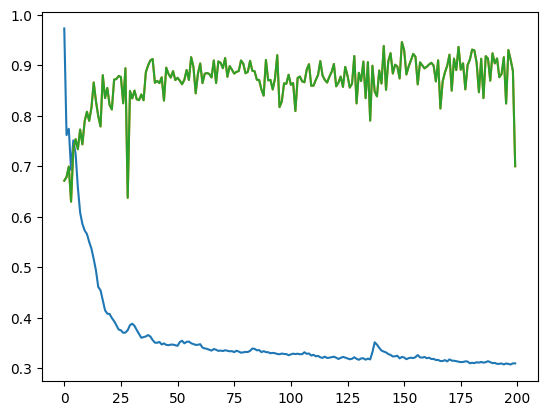

In [55]:
plot_loss_accuracy(clf1)

In [54]:
pred_probas, y_pred, test_acc = test_prediction(clf1, X_test_clf1, y_test_clf1)

FINAL TEST SCORE FOR Intellizenz : 0.87295
FINAL TEST SCORE FOR Intellizenz : 0.87295


In [29]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
wand_log(model=clf1,pred_probas=pred_probas, y_test= y_test_clf1, y_pred=y_pred, test_accuracy=test_acc)

wandb: WARNING wandb uses only 10000 data points to create the plots.


test_accuracy,▁
train_auc,▁▃▄▅▅▇▆▆▇▇▇▇▇▇█▇▇▆▇▇▇▇▇▇▇▆▆▆█▇███▇▇▆▆█▇▂
train_loss,█▇▅▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_auc,▁▃▄▅▅▇▆▆▇▇▇▇▇▇█▇▇▆▇▇▇▇▇▇▇▆▆▆█▇███▇▇▆▆█▇▂
test_accuracy,0.87295
train_auc,0.70031
train_loss,0.30969
validation_auc,0.70031


In [17]:
save_model(clf1,path="./baseline_tabnet_model_test_1")

TypeError: Object of type int32 is not JSON serializable

In [ ]:
# clf_1 = load_model(path="./baseline_tabnet_model_test_1")

In [ ]:
plot_loss_accuracy(clf1)
pred_probas, y_pred, test_acc = test_prediction(clf1, X_test_clf1, y_test_clf1)

wand_log(model=clf1,pred_probas=pred_probas, y_test= y_test_clf1, y_pred=y_pred, test_accuracy=test_acc)

### Classification 2

In [ ]:
# # For Classifier2 (clf2) we use data from segments 2 and 3 (so we drop records where y_clf2 is NaN)
# df_train_clf2 = df_train.dropna(subset=['y_clf2'])
# df_valid_clf2 = df_valid.dropna(subset=['y_clf2'])
# df_test_clf2 = df_test.dropna(subset=['y_clf2'])


# ## 77 input features - without tarif
# X_train_clf2 = df_train_clf2[feature_columns].values
# y_train_clf2 = df_train_clf2.y_clf2

# X_valid_clf2 = df_valid_clf2[feature_columns].values
# y_valid_clf2 = df_valid_clf2.y_clf2

# X_test_clf2 = df_test_clf2[feature_columns].values
# y_test_clf2 = df_test_clf2.y_clf2

In [63]:
# For Classifier2 (clf2) we use data from segments 2 and 3 (so we drop records where y_clf2 is NaN)
df_sampled_clf2 = df_sampled.dropna(subset=['y_clf2'])

n_total_clf2 = len(df_sampled_clf2)

# Train, val and test split follows
# Rory Mitchell, Andrey Adinets, Thejaswi Rao, and Eibe Frank.
# Xgboost: Scalable GPU accelerated learning. arXiv:1806.11248, 2018.

#Train set = 53%, test set = 20%, valid set = 26%
train_val_indices_clf2, test_indices_clf2 = train_test_split(
    range(n_total_clf2), test_size=0.2, random_state=0)
train_indices_clf2, valid_indices_clf2 = train_test_split(
    train_val_indices_clf2, test_size=0.2 / 0.6, random_state=0) #valid split = 33%(0.2/0.6)

In [64]:
## 77 input features - without tarif
X_train_clf2 = df_sampled_clf2[feature_columns].values[train_indices_clf2]
y_train_clf2 = df_sampled_clf2['y_clf2'].values[train_indices_clf2]

X_valid_clf2 = df_sampled_clf2[feature_columns].values[valid_indices_clf2]
y_valid_clf2 = df_sampled_clf2['y_clf2'].values[valid_indices_clf2]

X_test_clf2 = df_sampled_clf2[feature_columns].values[test_indices_clf2]
y_test_clf2 = df_sampled_clf2['y_clf2'].values[test_indices_clf2]

In [65]:
## Network parameters
clf2 = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15
)

max_epochs = 200 if not os.getenv("CI", False) else 2

aug = ClassificationSMOTE(p=0.2)
#SMOTE - Synthetic Minority Oversampling Technique
clf2.fit(
    X_train=X_train_clf2, y_train=y_train_clf2,
    eval_set=[(X_valid_clf2, y_valid_clf2), (X_valid_clf2, y_valid_clf2)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79975 | train_auc: 0.51936 | valid_auc: 0.51936 |  0:00:06s
epoch 1  | loss: 0.67614 | train_auc: 0.64283 | valid_auc: 0.64283 |  0:00:12s
epoch 2  | loss: 0.82021 | train_auc: 0.54176 | valid_auc: 0.54176 |  0:00:19s
epoch 3  | loss: 0.62083 | train_auc: 0.65114 | valid_auc: 0.65114 |  0:00:25s
epoch 4  | loss: 0.5716  | train_auc: 0.58929 | valid_auc: 0.58929 |  0:00:32s
epoch 5  | loss: 0.51846 | train_auc: 0.57739 | valid_auc: 0.57739 |  0:00:38s
epoch 6  | loss: 0.48726 | train_auc: 0.64575 | valid_auc: 0.64575 |  0:00:45s
epoch 7  | loss: 0.4444  | train_auc: 0.67468 | valid_auc: 0.67468 |  0:00:52s
epoch 8  | loss: 0.42128 | train_auc: 0.68104 | valid_auc: 0.68104 |  0:00:59s
epoch 9  | loss: 0.44721 | train_auc: 0.66222 | valid_auc: 0.66222 |  0:01:06s
epoch 10 | loss: 0.43215 | train_auc: 0.66724 | valid_auc: 0.66724 |  0:01:12s
epoch 11 | loss: 0.39532 | train_auc: 0.73664 | valid_auc: 0.73664 |  0:01:19s
epoch 12 | loss: 0.37804 | train_auc: 0.75878 | vali

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [66]:
pred_probas_clf2, y_pred_clf2, test_acc_clf2 = test_prediction(clf2, X_test_clf2, y_test_clf2)

FINAL TEST SCORE FOR Intellizenz : 0.8855097840444813
FINAL TEST SCORE FOR Intellizenz : 0.8855097840444813


In [67]:
wand_log(model=clf2,pred_probas=pred_probas_clf2, y_test= y_test_clf2, y_pred=y_pred_clf2, test_accuracy=test_acc_clf2)

wandb: WARNING wandb uses only 10000 data points to create the plots.


test_accuracy,▁
train_auc,▃▁▅▆▆▇▆▇▆▇▇▇▇██▇▇▇█▇█▇▇▇▇▇▇▇▆▇▇▆▇▇█▇▆▇▇▇
train_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_auc,▃▁▅▆▆▇▆▇▆▇▇▇▇██▇▇▇█▇█▇▇▇▇▇▇▇▆▇▇▆▇▇█▇▆▇▇▇
test_accuracy,0.88551
train_auc,0.85613
train_loss,0.29017
validation_auc,0.85613


### Classification 2 save model, plot, visualization

In [19]:
save_model(clf2,path="./baseline_tabnet_model_test_1")

Successfully saved model at ./baseline_tabnet_model_test_1.zip


In [12]:
clf2 = load_model(path="./baseline_tabnet_model_test_1.zip")

# C:/Users/sgopalakrish/Downloads/intellizenz-model-training/Neuro-symbolic-AI/SLASH/TabNet/baseline_tabnet_model_test_1.zip

In [19]:
clf2

TabNetClassifier(n_d=64, n_a=64, n_steps=5, gamma=1.5, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.3, lambda_sparse=0.0001, seed=0, clip_value=2.0, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={'gamma': 0.95, 'step_size': 20}, mask_type='sparsemax', input_dim=77, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1)

In [23]:
# plot_loss_accuracy(clf2)
pred_probas, y_pred, test_acc = test_prediction(clf2, X_test_clf2, y_test_clf2)

# wand_log(model=clf2,pred_probas=pred_probas, y_test= y_test_clf2, y_pred=y_pred, test_accuracy=test_acc)

FINAL TEST SCORE FOR Intellizenz : 0.7939848230658187
FINAL TEST SCORE FOR Intellizenz : 0.7939848230658187


## ===============================================

In [73]:
max_epochs = 200 if not os.getenv("CI", False) else 2

In [74]:
print(len(X_train))
print(len(y_train))

929171
929171


In [9]:
x1 = torch.Tensor([-5])
print((-x1).pow(2))
print(-(x1).pow(2))

tensor([25.])
tensor([-25.])


In [75]:
aug = ClassificationSMOTE(p=0.2)
#SMOTE - Synthetic Minority Oversampling Technique
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=16384, virtual_batch_size=256,
    augmentations=aug
)

epoch 0  | loss: 1.11091 | train_accuracy: 0.43291 | valid_accuracy: 0.43104 |  0:01:34s
epoch 1  | loss: 0.90897 | train_accuracy: 0.41207 | valid_accuracy: 0.41024 |  0:03:01s
epoch 2  | loss: 0.77753 | train_accuracy: 0.4124  | valid_accuracy: 0.4106  |  0:04:38s
epoch 3  | loss: 0.70817 | train_accuracy: 0.41161 | valid_accuracy: 0.40982 |  0:06:11s
epoch 4  | loss: 0.69006 | train_accuracy: 0.4122  | valid_accuracy: 0.41044 |  0:07:43s
epoch 5  | loss: 0.66955 | train_accuracy: 0.41217 | valid_accuracy: 0.41034 |  0:09:20s
epoch 6  | loss: 0.65589 | train_accuracy: 0.41626 | valid_accuracy: 0.41463 |  0:10:53s
epoch 7  | loss: 0.63862 | train_accuracy: 0.41235 | valid_accuracy: 0.41055 |  0:12:25s
epoch 8  | loss: 0.62312 | train_accuracy: 0.68671 | valid_accuracy: 0.68503 |  0:13:55s
epoch 9  | loss: 0.6107  | train_accuracy: 0.41196 | valid_accuracy: 0.41021 |  0:15:27s
epoch 10 | loss: 0.60104 | train_accuracy: 0.41201 | valid_accuracy: 0.41025 |  0:17:01s
epoch 11 | loss: 0.60

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


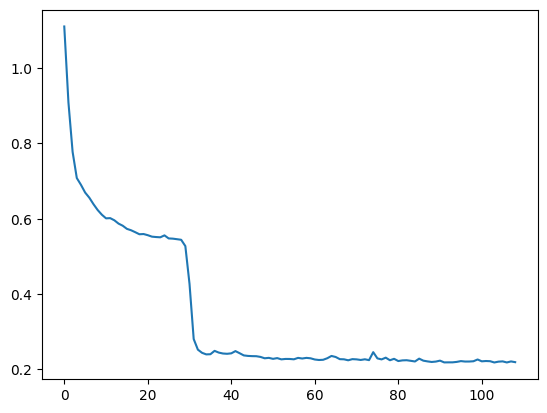

In [76]:
# plot losses
plt.plot(clf.history['loss'])

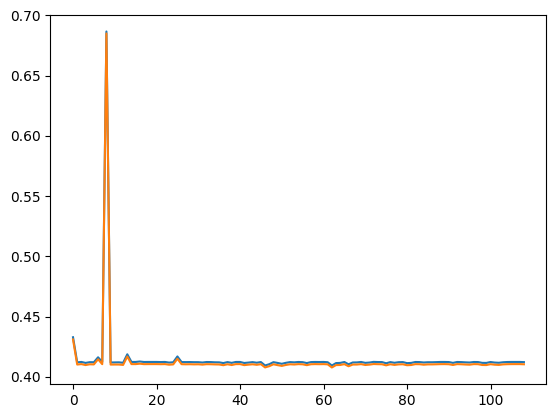

In [77]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

### Predictions

In [78]:
dataset_name = 'Intellizenz'

In [79]:
# To get final results you may need to use a mapping for classes 
# as you are allowed to use targets like ["yes", "no", "maybe", "I don't know"]

preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR Intellizenz : 0.6850314043040471
FINAL TEST SCORE FOR Intellizenz : 0.6848668350361612


In [80]:
# or you can simply use the predict method

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR Intellizenz : 0.6848668350361612


## Save and load Model

In [81]:
# save state dict
saving_path_name = "./baseline_tabnet_model_test_1"
saved_filename = clf.save_model(saving_path_name)

Successfully saved model at ./baseline_tabnet_model_test_1.zip


In [82]:
# define new model and load save parameters
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filename)

c:\Users\sgopalakrish\Downloads\intellizenz-model-training\Neuro-symbolic-AI\SLASH\TabNet\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [83]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR Intellizenz : 0.6848668350361612


In [84]:
import wandb

wandb.init(project="Intellizenz", entity="elsaravana")
wandb.config = {
    "learning_rate": 0.02,
    "epochs": 200,
    "batch_size": 16384
}

wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                    preds=loaded_y_pred, y_true=y_test,
                    class_names=[0, 1, 2])})
wandb.log({"pr" : wandb.plot.pr_curve(y_true=y_test, y_probas=loaded_preds,
             labels=['Segment 0-50€', 'Segment 50-100€', 'Segment >100€'], classes_to_plot=[0, 1, 2])})
wandb.log({"roc" : wandb.plot.roc_curve(y_true=y_test, y_probas=loaded_preds,
                labels=['Segment 0-50€', 'Segment 50-100€', 'Segment >100€'], classes_to_plot=[0, 1, 2])})

train_loss = clf.history['loss']
train_accuracy = clf.history['train_accuracy']
validation_accuracy = clf.history['valid_accuracy']
for i,loss in enumerate(train_loss):
    wandb.log({"train_loss": loss, 
        "train_accuracy": train_accuracy[i],
        "validation_accuracy": validation_accuracy[i]})

wandb: WARNING wandb uses only 10000 data points to create the plots.


In [85]:
# wandb.summary["test_accuracy"] = loaded_test_acc
wandb.log({"test_accuracy": loaded_test_acc})

In [86]:
assert(test_acc == loaded_test_acc)

In [87]:
# exit_code 0, to finish a successful run
wandb.finish(0)

test_accuracy,▁
train_accuracy,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▅▄▄▄▄▄▄▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▂▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,0.68487
train_accuracy,0.41225
train_loss,0.21883
validation_accuracy,0.41047


## Global explainability: feature importance summing to 1

In [41]:
clf.feature_importances_

array([0.00000000e+00, 2.10643698e-02, 0.00000000e+00, 1.64264212e-07,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.36690251e-01,
       0.00000000e+00, 8.59264621e-08, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.48906630e-07,
       1.48675966e-03, 0.00000000e+00, 6.79421350e-06, 0.00000000e+00,
       1.08364009e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.11248307e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.09456074e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.04016911e-02, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.47142230e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.78974153e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.92397352e-04,
      

## Local explainability and masks

In [42]:
explain_matrix, masks = clf.explain(X_test)

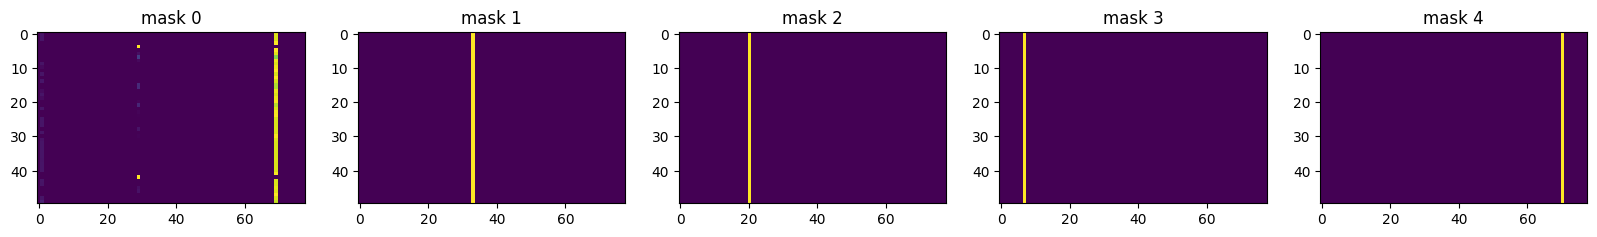

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")